In [1]:
#import libraries
import requests
from bs4 import BeautifulSoup
import json
import numpy as np
import pandas as pd
import re 
import openpyxl
import time
from urllib.request import urlopen
from os import listdir
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import langid
import investpy
import warnings
import time
warnings.filterwarnings("ignore")

[Data extraction](#Data-Extraction)  
[Exploratory Data Analysis](#Exploratory-Data-Analysis)


### Data Extraction

In [2]:
#get number of pages
s=requests.Session()
url = 'https://api.hh.ru/vacancies'
params={'text':('data scientist'),'order_by':('publication_time'),'per_page':(100)}
request_=s.get(url, params=params).json()
n_pages=request_['pages']
n_pages

4

In [3]:
##get urls to full vacancy descriptions
## if number of pages > 20, download for every day
download_urls=list()
if n_pages < 20:
    for page in range(n_pages):
        params_={'text':('data scientist'),'per_page':(100),'page':(page), 'order_by':('publication_time')}
        pages_=s.get(url, params=params_).json()
        download_urls.extend([alt_url['alternate_url'] for alt_url in pages_['items']])
        time.sleep(2)
else:
    for n_day in range(0,40):# it is said in docs that period of 30 days is available only, but I found more valid days
        date = (datetime.today()-timedelta(days=n_day)).strftime('%Y-%m-%d')#iterate through all days
        param_={'text':('data scientist'),'date_to':(date),'date_from':(date),'order_by':('publication_time'),'per_page':(100)}
        pages_=s.get(url, params=param_).json()
        n_pages_=pages_['pages']# get number of pages per day
        for p in range(n_pages_):
            par={'text':('data scientist'),'page':(p),'date_to':(date),'date_from':(date),'order_by':('publication_time'),'per_page':(100)}
            answer=s.get(url, params=par).json()
            download_urls.extend([alt_url['alternate_url'] for alt_url in answer['items']])
        time.sleep(2)
download_urls=[download_urls[j][-8:] for j in range(len(download_urls))]

In [4]:
#check that vacancy was not seen before (check for vacancy url in the folder where vacancies are saved in json)
previous_vac=[jsfile[:-5] for jsfile in listdir('C:/Users/Dell/Desktop/Py_projects/headhunter_parser/vacancies/')]
new_url_list=[]
for val in download_urls:
    if val not in previous_vac:
        new_url_list.append(val)

In [5]:
#get vacancy descriptions and save in json
vac=list()
link='https://api.hh.ru/vacancies/{}'
try:
    for url in new_url_list:
        vacancy_desc=s.get(link.format(url)).json()
        if vacancy_desc['description']!='Not Found':
            with open('C:/Users/Dell/Desktop/Py_projects/headhunter_parser/vacancies/'+str(url)+'.json', 'w') as file:
                json.dump(vacancy_desc, file)
            vac.append(vacancy_desc)
except KeyboardInterrupt:
    pass

In [6]:
#read all previous vacancies from folder
vacancies=[]
all_vac=listdir('C:/Users/Dell/Desktop/Py_projects/headhunter_parser/vacancies/')
for f in all_vac:
    with open('C:/Users/Dell/Desktop/Py_projects/headhunter_parser/vacancies/{}'.format(f)) as f_json:
        one_file=json.load(f_json)
        vacancies.append(one_file)

In [7]:
#extract data
employer=[]
spec=[]
prof_area=[]
description=[]
name=[]
location=[]
salary=[]
exp=[]
schedule=[]
skills=[]
for job in vacancies:
    employer.append(job['employer']['name'])
    spec.append(job['specializations'][0]['name'])
    prof_area.append(job['specializations'][0]['profarea_name'])
    description.append(job['description'])
    name.append(job['name'])
    location.append(job['area']['name'])
    salary.append(job['salary'])
    exp.append(job['experience']['name'])
    schedule.append(job['schedule']['name'])
    skills.append(job['key_skills'])

In [8]:
#some vacancies are in foreign currency, so get current exchange rates to convert to RUB
currency=[]
fx=dict()
for sal in salary:
    if sal!=None:
        currency.append(sal['currency'])
available_cur=list(set(currency))
today=datetime.today().strftime('%d/%m/%Y')
yesterday=(datetime.today()-timedelta(days=2)).strftime('%d/%m/%Y')
for cur in available_cur:
    if cur not in (None,'RUR'):
        cur_data=investpy.currency_crosses.get_currency_cross_historical_data(currency_cross='{}/RUB'.format(cur), from_date=yesterday, to_date=today,order='descending')
        cur_data=pd.DataFrame(cur_data)
        fx[cur]=cur_data.iloc[0,3].astype(float)
fx['RUR']=1

In [9]:
#clear skills and description, convert salary 
clear_desc=[]
salary_clear=[]
skills_clear=[]
for desc in description:    
    string=re.sub('<[a-z]>|<[a-z][a-z]>+|<strong>|&#[0-9][0-9]|\u200b+','',desc)
    string=re.sub('</[a-z]>|</[a-z][a-z]>|</strong>+','',string)
    clear_desc.append(string)
    
for sal in salary:
    if sal!=None:
        chosen_cur=(sal['currency'])
        try: 
            salary_clear.append(((sal['from']+sal['to'])/2)*fx[chosen_cur])
        except TypeError:
            if sal['from']!=None:
                salary_clear.append(sal['from']*fx[chosen_cur])
            else: 
                salary_clear.append(sal['to']*fx[chosen_cur])
    else:
        salary_clear.append(0)
        
for skill in skills:
    if skill==[]:
        skills_clear.append(None)
    else:
        skills_clear.append([sk['name'] for sk in skill])

In [10]:
all_data=pd.DataFrame([name,employer,spec,prof_area,exp,salary_clear,schedule,location,skills_clear,clear_desc]).transpose()
all_data.columns=['vacancy','company','specialization','prof_area','experience','salary','schedule','city','skills','description']
all_data.head()

,vacancy,company,specialization,prof_area,experience,salary,schedule,city,skills,description
0,Data Engineer,ЦИАН ГРУПП,"Программирование, Разработка","Информационные технологии, интернет, телеком",От 1 года до 3 лет,0,Полный день,Москва,"[Hadoop, Kafka, Spark, Iron Python, OLAP-струк...",Циан - крупнейший в России сервис для поиска н...
1,Data Scientist,МФИ Софт,"Информатика, Информационные системы","Наука, образование",От 3 до 6 лет,0,Гибкий график,Нижний Новгород,"[SQL, Python]",МФИ Софт занимается передовыми разработками по...
2,Data Scientist,ANCOR FinTech,"Программирование, Разработка","Информационные технологии, интернет, телеком",От 1 года до 3 лет,0,Полный день,Екатеринбург,None,"Технологический стек: Oracle Exadata (SQL, PL/..."
3,Главный аналитик-математик (Data Analyst / Dat...,Связной,"Информатика, Информационные системы","Наука, образование",От 3 до 6 лет,0,Полный день,Москва,"[Data Mining, Python, Управление проектами, Da...",Требования: Высшее образование (приветствуютс...
4,Исследователь данных / Data Scientist / Аналитик,ДДОС ГВАРД,Передача данных и доступ в интернет,"Информационные технологии, интернет, телеком",От 3 до 6 лет,0,Полный день,Ростов-на-Дону,"[Python, C/C++, Data Analysis, Big Data]","Компания DDoS-GUARD - оператор связи, занимающ..."


In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   vacancy         402 non-null    object
 1   company         402 non-null    object
 2   specialization  402 non-null    object
 3   prof_area       402 non-null    object
 4   experience      402 non-null    object
 5   salary          402 non-null    object
 6   schedule        402 non-null    object
 7   city            402 non-null    object
 8   skills          263 non-null    object
 9   description     402 non-null    object
dtypes: object(10)
memory usage: 15.8+ KB


### Exploratory Data Analysis

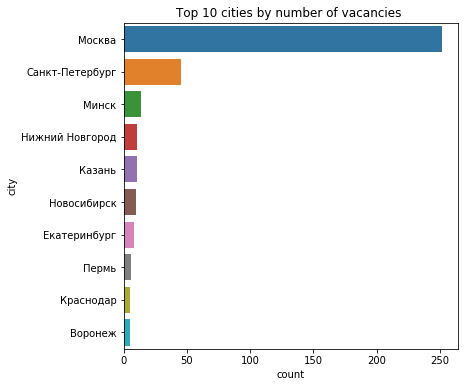

In [12]:
plt.figure(figsize=(6,6))
sns.countplot(y='city',data=all_data[['city']],order = all_data['city'].value_counts().iloc[:10].index).set_title('Top 10 cities by number of vacancies ');

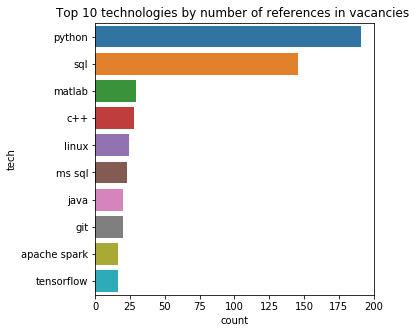

In [13]:
# here I distinguish b/n technology (tools) and skills(in theoretical meaning)
all_skills=[]
technology=[]
skill=[]
for list_ in skills_clear: #get from all vacancies
    if list_ != None:
        for item_ in list_:
            all_skills.append(item_.lower())
for _item in range(len(all_skills)): #replace irems with same meaning by common word
    if all_skills[_item] in ('data analysis', 'аналитические исследования','data science','analytical skills','аналитическое мышление'):
        all_skills[_item]="анализ данных"  
    elif all_skills[_item] in ('mysql','postgresql', 'oracle pl/sql'):
        all_skills[_item]='sql'
    elif all_skills[_item]=='spark':
        all_skills[_item]='apache spark'

for skil in all_skills: #append to skill and technology lists
    if skil in ('data analysis','machine learning','ml','nlp','deep learning'):
        skill.append(skil)
    elif skil=='c/c++':
        technology.extend(['c','c++'])
    elif skil in ('keras','pandas','linux'):
        technology.append(skil)   
    else:
        if list(langid.classify(skil))[0]=='en':#assume that technologies are most often written in English
            technology.append(skil)
        else:
            skill.append(skil)
technology_df=pd.DataFrame(technology,columns=['tech'])
plt.figure(figsize=(5,5))
sns.countplot(y='tech',data=technology_df,order = technology_df['tech'].value_counts().iloc[:10].index).set_title('Top 10 technologies by number of references in vacancies ');

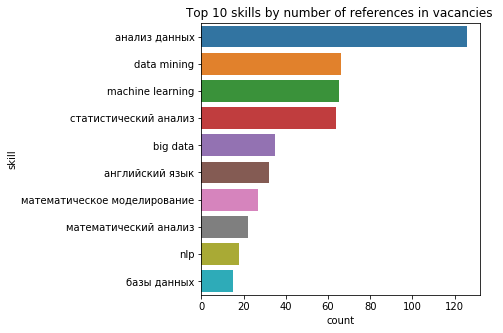

In [14]:
for sk_ in range(len(skill)):
    if skill[sk_] in ('ml', 'машинное обучение'):
        skill[sk_]='machine learning'
    elif skill[sk_] in ('математическая статистика', 'статистика', 'регрессионный анализ'):
        skill[sk_]='статистический анализ'
    elif skill[sk_]=='работа с базами данных':
        skill[sk_]='базы данных'
    elif skill[sk_]=='работа с большим объемом информации':
        skill[sk_]='big data'
skill_df=pd.DataFrame(skill,columns=['skill'])
plt.figure(figsize=(5,5))
sns.countplot(y='skill',data=skill_df,order = skill_df['skill'].value_counts().iloc[:10].index).set_title('Top 10 skills by number of references in vacancies ');

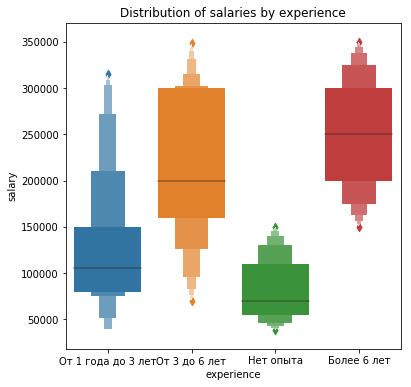

In [21]:
data_for_sal=all_data[(all_data.loc[:,'salary']!=0)]
data_for_sal.loc[:,'salary']=data_for_sal.loc[:,'salary'].astype(float)
plt.figure(figsize=(6,6))
sns.boxenplot(y='salary', x='experience',data=data_for_sal).set_title('Distribution of salaries by experience');

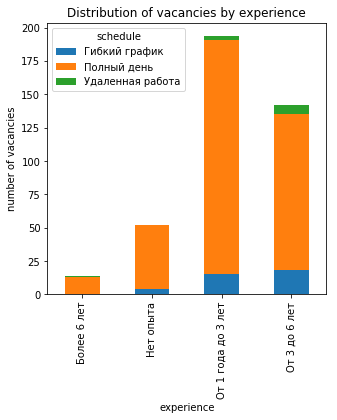

In [25]:
exp_sch=pd.crosstab(index=all_data['experience'], columns=all_data['schedule'])
exp_plot=exp_sch.plot(kind="bar", 
                 figsize=(5,5),
                 stacked=True,title='Distribution of vacancies by experience')
exp_plot.set_ylabel("number of vacancies");

In [17]:
vac_sum=all_data.shape[0]
sched_stats=pd.DataFrame([all_data.groupby('schedule').count().loc[:,'vacancy']/vac_sum,all_data.groupby('schedule').count().loc[:,'vacancy']]).transpose()
sched_stats.columns=['percentage from all vacancies','number of vacancies']
sched_stats

,percentage from all vacancies,number of vacancies
schedule,,
Гибкий график,0.092040,37.0
Полный день,0.880597,354.0
Удаленная работа,0.027363,11.0


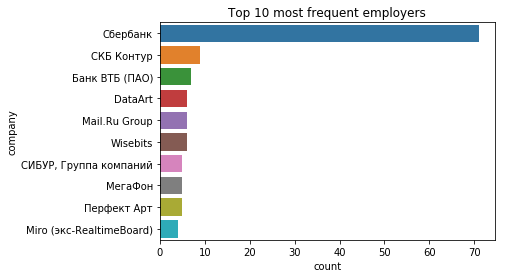

In [18]:
sns.countplot(y='company',data=all_data[['company']],order = all_data['company'].value_counts().iloc[:10].index).set_title('Top 10 most frequent employers');

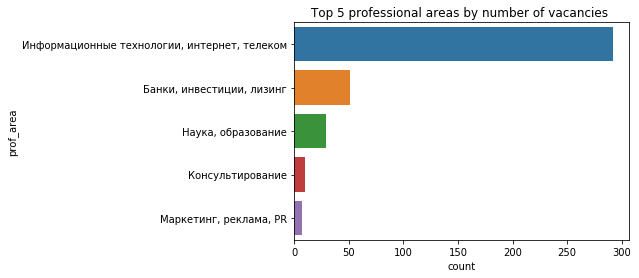

In [19]:
sns.countplot(y='prof_area',data=all_data[['prof_area']],order = all_data['prof_area'].value_counts().iloc[:5].index).set_title('Top 5 professional areas by number of vacancies ');